# Generalization of Steamboat to Visium Data

- Data: [10x Genomics: Human Breast Cancer (Block A Section 1)](https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0)
- Tasks: Test how much Steamboat generalizes to spot-level data

In [1]:
import sys
sys.path.append("../") # Append the parent directory to Steamboat package, not needed if installed via pip

import scanpy as sc
import squidpy as sq
import pandas as pd
from tqdm.notebook import tqdm
import scipy as sp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import torch
import gc

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

import steamboat as sf

device = "cuda" # this dataset is small and should also work with "cpu"


plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
matplotlib.rcParams['font.family'] = 'arial'

c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\spatialdata\_core\query\relational_query.py:530: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left = partial(_left_join_spatialelement_table)
c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\spatialdata\_core\query\relational_query.py:531: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left_exclusive = parti

## Load data

In [2]:
adata = sq.read.visium("../../SEDR_analyses/data/BRCA1/V1_Human_Breast_Cancer_Block_A_Section_1")
annotation = pd.read_csv("../../SEDR_analyses/data/BRCA1/metadata.tsv", sep="\t", index_col=0)
adata.obs = adata.obs.join(annotation)
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata.X = np.array(adata.X.todense())

c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\anndata\_core\anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\anndata\_core\anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Train Steamboat model

In [3]:
# Prepare Steamboat dataset
adata.obs['global'] = 0
adatas = sf.prep_adatas([adata], n_neighs=6, norm=False, log1p=False, scale=False, renorm=False)
dataset = sf.make_dataset(adatas, sparse_graph=True, regional_obs=['global'], mask_var='highly_variable')

  0%|          | 0/1 [00:00<?, ?it/s]

Using ['global'] as regional annotations.


  0%|          | 0/1 [00:00<?, ?it/s]

Not all cells in the following samples have the same number of neighbors:
0.
Steamboat can handle this. You can safely ignore this warning if this is expected.


In [4]:
if True: # Instead of training, you can load the trained model by setting this to False
    # Move dataset to GPU
    cuda_dataset = dataset.to(device)

    # Train Steamboat model
    sf.set_random_seed(0)
    model = sf.Steamboat(adatas[0].var_names[adatas[0].var['highly_variable']].tolist(), n_heads=20, n_scales=3)
    model = model.to(device)
    model.fit(cuda_dataset, entry_masking_rate=0.1, feature_masking_rate=0.1,
            max_epoch=10000, 
            loss_fun=torch.nn.MSELoss(reduction='sum'),
            opt=torch.optim.Adam, opt_args=dict(lr=0.01), stop_eps=1e-3, report_per=1000, stop_tol=200, device=device)
    
    # Save the trained model
    torch.save(model.state_dict(), "saved_models/visium_breast_cancer.pth")
else:
    model = sf.Steamboat(adatas[0].var_names[adatas[0].var['highly_variable']].tolist(), n_heads=20, n_scales=3)
    model = model.to(device)
    model.load_state_dict(torch.load("saved_models/visium_breast_cancer.pth"))

[2026-02-02 22:46:23,562::train::INFO] Epoch 1: train_loss 1246.47009
[2026-02-02 22:46:29,042::train::INFO] Epoch 1001: train_loss 599.93884
[2026-02-02 22:46:34,522::train::INFO] Epoch 2001: train_loss 588.02606
[2026-02-02 22:46:40,003::train::INFO] Epoch 3001: train_loss 581.84174
[2026-02-02 22:46:45,444::train::INFO] Epoch 4001: train_loss 576.77502
[2026-02-02 22:46:50,830::train::INFO] Epoch 5001: train_loss 572.27618
[2026-02-02 22:46:56,214::train::INFO] Epoch 6001: train_loss 570.30090
[2026-02-02 22:47:01,610::train::INFO] Epoch 7001: train_loss 569.72449
[2026-02-02 22:47:07,041::train::INFO] Epoch 8001: train_loss 568.99103
[2026-02-02 22:47:08,000::train::INFO] Epoch 8176: train_loss 569.16351
[2026-02-02 22:47:08,001::train::INFO] Stopping criterion met.


## Find spatial domains

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Files\projects\Steamboat\examples\..\steamboat\tools.py:725: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return sc.tl.leiden(adata, obsp=obsp, key_added=key_added, resolution=resolution, **leiden_kwargs)
c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\squidpy\pl\_spatial_utils.py:982: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\squidpy\pl\_spatial_utils.py:982: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


NMI: 0.6263, ARI: 0.5647, n_clusters: 12


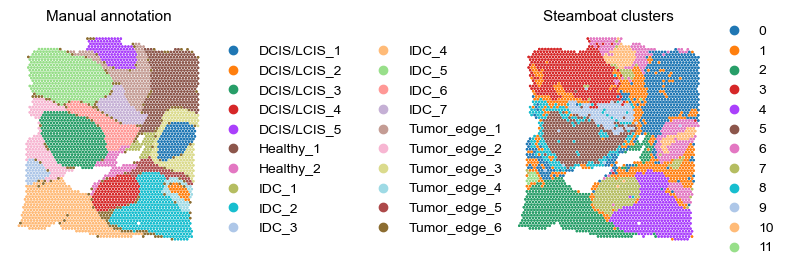

In [5]:
sf.tools.calc_obs(adatas, dataset, model, get_recon=True)

i = 0
sf.tools.neighbors(adatas[i], use_rep='attn')
sf.tools.leiden(adatas[i], resolution=0.6)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sq.pl.spatial_scatter(adatas[i], color=["fine_annot_type", "steamboat_clusters"], shape=None, fig=fig, ax=axes, size=2.5, frameon=False)

labels_pred = adata.obs['steamboat_clusters'].values
labels_true = adata.obs['fine_annot_type'].values
nmi = normalized_mutual_info_score(labels_true, labels_pred)
ari = adjusted_rand_score(labels_true, labels_pred)

n_clusters = adata.obs['steamboat_clusters'].nunique()

print(f"NMI: {nmi:.4f}, ARI: {ari:.4f}, n_clusters: {n_clusters}")

axes[0].set_title("Manual annotation", fontsize=11)
axes[1].set_title("Steamboat clusters", fontsize=11)
fig.tight_layout(pad=2.)